<a href="https://colab.research.google.com/github/whc324/CIVE_70019_70057/blob/main/notebooks/coursework_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coursework: Hydraulic model calibration


### CIVE 70019/70057
Department of Civil and Environmental Engineering, Imperial College London

You have been tasked with the evaluation and calibration of the hydraulic model of EXNING, a district metered area (DMA) in Anglian Water's (AW) water distribution network. To achieve this, you have been provided:
* a recently calibrated hydraulic model of the EXNING DMA (2019),
* loading conditions (demands, reservoir heads) and head measurements covering a period of 4 days.

The objective of the coursework is to prepare a short calibration report for AW by completing the tasks below and answering the questions based on your results.

You have been provided the following information about EXNING:
* EXNING is part of a larger system of cascading DMAs: EXNING is fed by the NEWSEV DMA and feeds into the BURWEL DMA.
* The "reservoir" head and total demand of EXNING are derived from flow and pressure sensors at the DMA inlet (& outlet).
* Node elevations have been updated in the provided model following a GPS survey of sensor locations.

First, we must clone the GitHub repository and install dependencies (only run this once).

In [ ]:
# Force reinstall core packages
!pip uninstall -y numpy wntr cvxpy ecos scs
!pip install numpy --no-cache-dir --force-reinstall
!pip install wntr cvxpy scs ecos
!apt-get install -y libsuitesparse-dev
!pip install scikit-sparse

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: cvxpy 1.6.4
Uninstalling cvxpy-1.6.4:
  Successfully uninstalled cvxpy-1.6.4
Found existing installation: scs 3.2.7.post2
Uninstalling scs-3.2.7.post2:
  Successfully uninstalled scs-3.2.7.post2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 122.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 39.5 MB/s eta 

In [ ]:
# run this cell once
import sys
import os

if 'google.colab' in sys.modules:
  !git clone https://github.com/bradleywjenks/CIVE_70019_70057.git
  !pip install numpy==1.23.5
  !pip install wntr==1.2
  !pip install cvxpy
  !apt-get install libsuitesparse-dev && pip install scikit-sparse

fatal: destination path 'CIVE_70019_70057' already exists and is not an empty directory.
  Using cached wntr-1.2.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 48.0 MB/s eta 0:00:00
  Attempting uninstall: wntr
    Found existing installation: wntr 1.3.2
    Uninstalling wntr-1.3.2:
      Successfully uninstalled wntr-1.3.2
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libsuitesparse-dev is already the newest version (1:5.10.1+dfsg-4build1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [ ]:
# load packages
import numpy as np
from numpy import linalg as la
import networkx as nx
import pandas as pd
import wntr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import copy
from datetime import datetime, timedelta
import cvxpy as cp
import warnings
warnings.filterwarnings('ignore')

# improve matplotlib image quality
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

### Load network properties and operational data

Load functions created in previous assignments.

In [ ]:
# load functions from src folder
if 'google.colab' in sys.modules:
    sys.path.append('/content/CIVE_70019_70057/src/')
    from general_functions import *
    from hydraulic_functions import *
else:
    sys.path.append('/home/bradw/workspace/CIVE_70019_70057/src/')
    from general_functions import *
    from hydraulic_functions import *

Load network .inp file and operational data from the module repository's data directory.

In [ ]:
if 'google.colab' in sys.modules:
    # if run in Google Colab
    data_dir = '/content/CIVE_70019_70057/data/parameter_estimation/'
    net_dir = '/content/CIVE_70019_70057/data/networks/'
else:
    # replace with local directory
    data_dir = '/home/bradw/workspace/CIVE_70019_70057/data/parameter_estimation/'
    net_dir = '/home/bradw/workspace/CIVE_70019_70057/data/networks/'

net_name = 'exning.inp'
data_name = 'exning_coursework_dataset.npy'

# load operational data
data = np.load(os.path.join(data_dir, data_name), allow_pickle=True).item()
h_data = data['h_data']
sensor_idx = data['sensor_idx'] - 1 # matlab to python index offset
d_data = data['d']
h0_data = data['h0'].reshape(-1, 1).T

# load network properties
wdn = load_network_data(os.path.join(net_dir, net_name))
A12 = wdn.A12
A10 = wdn.A10
net_info = wdn.net_info
link_df = wdn.link_df
node_df = wdn.node_df
demand_df = wdn.demand_df

Plot sensor nodes in network. We provide a plotting function below.

In [ ]:
#### DO NOT CHANGE THIS ####
# define plotting function using networkx
def plot_network(wdn, sensor_idx, vals=None, highlight_valves=None):

    # create figure and axis
    fig, ax = plt.subplots(figsize=(10, 7))

    # unload data
    link_df = wdn.link_df
    node_df = wdn.node_df
    net_info = wdn.net_info

    # draw network
    uG = nx.from_pandas_edgelist(link_df, source='node_out', target='node_in')
    pos = {row['node_ID']: (row['xcoord'], row['ycoord']) for _, row in node_df.iterrows()}
    nx.draw(uG, pos, ax=ax, node_size=20, node_shape='o')

    # draw reservoir
    nx.draw_networkx_nodes(
        uG, pos, nodelist=net_info['reservoir_names'],
        node_size=100, node_shape='s', node_color='black', ax=ax
    )

    # draw sensor nodes
    sensor_names = [net_info['junction_names'][i] for i in sensor_idx]
    nx.draw_networkx_nodes(
        uG, pos, nodelist=sensor_names, node_size=100,
        node_shape='o', node_color='red', edgecolors='white', ax=ax
    )

    # reservoir labels
    reservoir_labels = {node: 'Reservoir' for node in net_info['reservoir_names']}
    labels_res = nx.draw_networkx_labels(uG, pos, reservoir_labels, font_size=12, ax=ax)
    for _, label in labels_res.items():
        label.set_y(label.get_position()[1] + 1750)

    # sensor labels
    sensor_labels = {node: str(idx+1) for (idx, node) in enumerate(sensor_names)}
    labels_sen = nx.draw_networkx_labels(uG, pos, sensor_labels, font_size=12, ax=ax)
    for _, label in labels_sen.items():
        label.set_y(label.get_position()[1] + 1750)

    # plot sensor values if provided
    if vals is not None:
        cmap = cm.get_cmap('RdYlGn_r')
        nx.draw_networkx_nodes(
            uG, pos, nodelist=sensor_names, node_size=100,
            node_shape='o', node_color=vals, cmap=cmap, edgecolors='white', ax=ax
        )

        # create color bar
        sm = plt.cm.ScalarMappable(cmap=cmap)
        sm.set_array(vals)
        colorbar = plt.colorbar(sm, ax=ax)
        colorbar.set_label('Mean pressure residual [m]', fontsize=12)

    # highlight link
    if highlight_valves is not None:
        nx.draw_networkx_nodes(uG, pos, highlight_valves, node_size=200, node_shape='d', node_color='limegreen', edgecolors='white')

    # display plot
    plt.show()

Visualise the EXNING network graph and highlight information relevant to the evaluation of the hydraulic model.

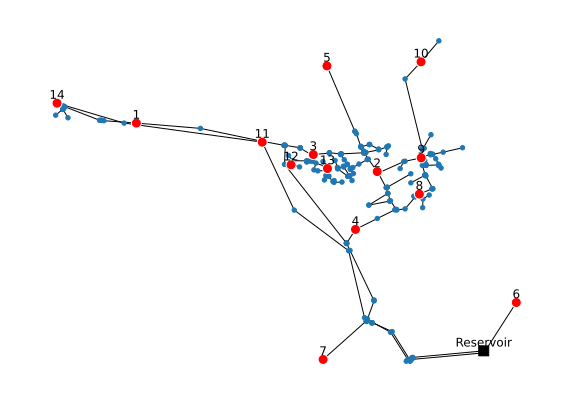

In [ ]:
 plot_network(wdn, sensor_idx)

Simulate initial (uncalibrated) network hydraulics over 4 days. We first define a function to solve network hydraulics using the `wntr` package, which we used previously in the hyraulic modelling notebook. The following tasks are performed in this function:
- Load network properties
- Modify simulation time to match operational data
- Assign h0 data at model reservoir
- Scale and apply new demand pattern from inflow data
- Option to modify pipe roughness (or HW) coefficients

<font color="blue">NB: this is done for you below. Provided the correct inputs, you do not need to replicate this function.

In [ ]:
#### DO NOT CHANGE THIS ####
# hydraulic solver function
def hydraulic_solver(inp_file, d_data, h0_data, C=None, demand=False):

    # load network from wntr
    inp_file = os.path.join(net_dir, net_name)
    wn = wntr.network.WaterNetworkModel(inp_file)

    # get network properties
    reservoir_names = wn.reservoir_name_list
    junction_names = wn.junction_name_list
    link_names = wn.link_name_list

    # modify simulation time and hydraulic time step
    nt = h0_data.shape[1]
    wn.options.time.duration = (nt - 1) * 3600
    wn.options.time.hydraulic_timestep = 3600
    wn.options.time.pattern_timestep = 3600
    wn.options.time.report_timestep = 3600

    # assign reservoir data
    for (i, name) in enumerate(reservoir_names):
        wn.add_pattern(f'h0_{i}', h0_data[i])
        reservoir = wn.get_node(name)
        reservoir.head_timeseries.base_value = 1
        reservoir.head_timeseries.pattern_name = wn.get_pattern(f'h0_{i}')

    # replace demand data
    for idx, name in enumerate(junction_names):

        if any(val != 0 for val in d_data[idx, :]):
            node = wn.get_node(name)
            d_pat = d_data[idx, :]
            wn.add_pattern('d_'+name, d_pat)

            for (i, num) in enumerate(node.demand_timeseries_list):
                if i == 0:
                    node.demand_timeseries_list[i].base_value = 1
                    node.demand_timeseries_list[i].pattern_name = 'd_'+name
                else:
                    node.demand_timeseries_list[i].base_value = None
                    node.demand_timeseries_list[i].pattern_name = None

    # assign roughness (or HW) coefficients
    if C is not None:
        for name, link in wn.links():

            # check if the link is a pipe
            if isinstance(link, wntr.network.Pipe):
                link.roughness = C[link_names.index(name)]

            # check if link is a valve
            elif isinstance(link, wntr.network.Valve):
                link.minor_loss = C[link_names.index(name)]
                link.initial_setting = C[link_names.index(name)]

    # run simulation and get results
    sim = wntr.sim.EpanetSimulator(wn)
    results = sim.run_sim()

    q_sim = results.link['flowrate'].T
    h_sim = results.node['head'].T
    h_sim = h_sim[~h_sim.index.isin(reservoir_names)] # delete reservoir nodes
    d = results.node['demand'].T
    d = d[~d.index.isin(reservoir_names)] # delete reservoir nodes


    if demand == True:
        return d.to_numpy()
    else:
        return q_sim.to_numpy(), h_sim.to_numpy()

### Part 0: Preliminary evaluation

Run simulation with initial $C_0$ values.

In [ ]:
C_0 = link_df['C'].to_numpy()
_, h_0 = hydraulic_solver(wdn, d_data, h0_data, C=C_0)

Compare simulated heads at sensor nodes (node indices in `sensor_idx`) with the simulated heads over the 4-day period. Visualise the results with, e.g. a boxplot of pressure residuals on the test dataset.

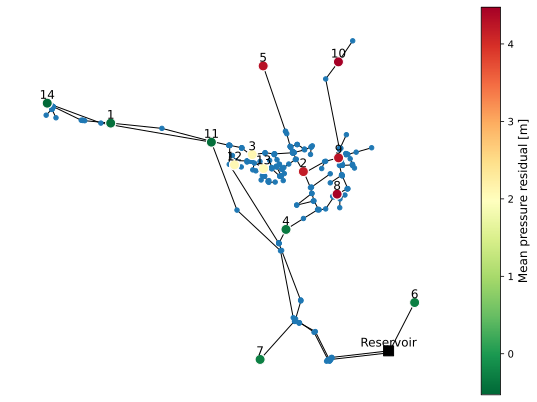

In [ ]:
# compute pressure residuals (spatial residual plot)
residuals_0 = h_0[sensor_idx,:] - h_data
meanresiduals_0=np.mean(residuals_0,axis=1)
plot_network(wdn,sensor_idx,vals=meanresiduals_0)

Text(0, 0.5, 'Pressure residual [m]')

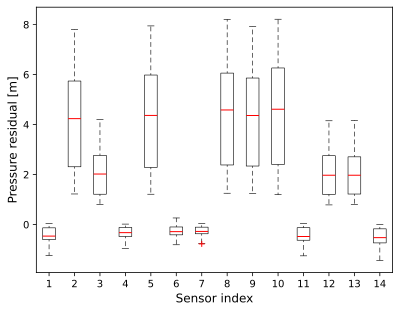

In [ ]:
fig, ax = plt.subplots()
boxplot = ax.boxplot(residuals_0.T, medianprops=dict(color="red", linewidth=1.0), flierprops=dict(marker="+", markeredgecolor="red"), whiskerprops=dict(linestyle=(5, (8, 5)), linewidth=0.6), boxprops=dict(color='black', linewidth=0.6), capprops=dict(linewidth=0.6))
ax.set_xlabel('Sensor index', fontsize=12)
ax.set_ylabel('Pressure residual [m]', fontsize=12)


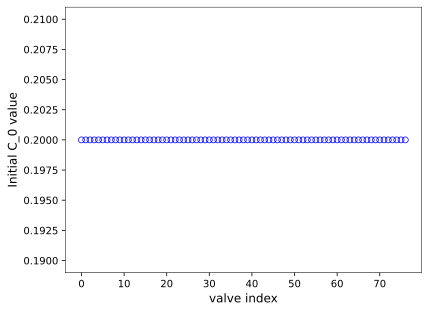

In [ ]:
# C_0 value scatter plot (valves only)
valve_C = [C_0[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
fig, ax = plt.subplots()
ax.scatter(range(len(valve_C)), valve_C, facecolors='none', edgecolors='b',linewidths=0.75)
ax.set_xlabel('valve index', fontsize=12)
ax.set_ylabel('Initial C_0 value', fontsize=12)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

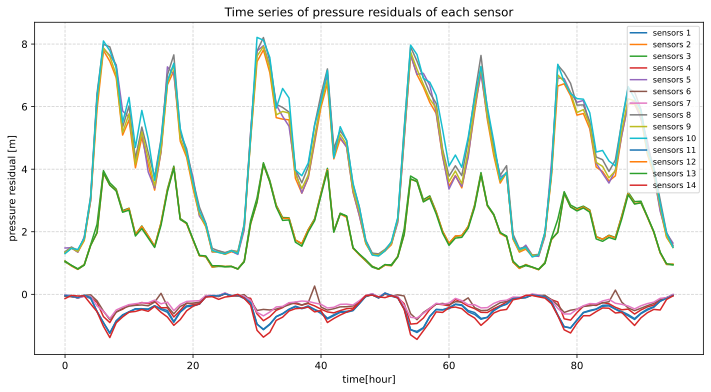

In [ ]:
plt.figure(figsize=(12, 6))
time_hours = np.arange(residuals_0.shape[1])
for i in range(residuals_0.shape[0]):
    plt.plot(time_hours, residuals_0[i, :], label=f'sensors {i+1}')
plt.xlabel('time[hour]')
plt.ylabel('pressure residual [m]')
plt.title('Time series of pressure residuals of each sensor')
plt.legend(loc='upper right', fontsize=8)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

**<u>Question 1:</u>** Is the current hydraulic model of EXNING accurate according to hydraulic model calibration guidelines? Comment on the results of the preliminary model evaluation and, in particular, on
* the **sign** (i.e. are heads over or underestimated in the hydraulic simulation?) of pressure/head residuals,
* the **temporal** distribution (i.e. are the residuals time/flow dependent?) of pressure/head residuals,
* and the **spatial** distribution (i.e. are all sensors affected?) of the pressure/head residuals.

Given the information you were provided about the EXNING system and the results of the preliminary model evaluation, identify the most likely sources of model errors.

From the box plot, most sensors exhibit positive residuals, indicating that the model tends to overestimate heads compared to measurements. However, sensors 1, 4, 6, 7, 11, and 14 show slightly negative residuals, indicating underestimation. The time series plot shows that these residuals vary over the day, growing during peak demand hours and decreasing during offpeak times. The mean residual plot show spatial variability: the residual is high in high density user area, and low in less density area. Overall, many residuals exceed the acceptable limit of 1.0 m（except1,4,6,7,11,14）, suggesting the current hydraulic model requires refinement. Potential error sources include inaccurate pipe roughness parameters and local loss or flow pattern assumptions.

### Part 1: Hydraulic model calibration (without regularisation)

Following initial reports concerning discrepancies in the recently calibrated EXNING model, AW were able to confirm that:
- flow and head sensors had been calibrated before collection of load/field data corresponding to the train and test datasets,
- demands in the train and test dataset are accurate (incl. for large users).

As a result, the remaining deviations between measured and simulated pressures must result from inaccurate model parameters. Errors associated with unknown valve status (for instance, unregistered closed valves) can be identified by solving a model calibration problem where pipe roughness coefficients are known, but valve minor/local loss coefficients are free to vary. In part 1, you will solve a hydraulic model calibration problem without regularisation. Complete the code below to calibrate the network model using the head measurements provided in data.

#### Split the data into *train* and *test* datasets.
We suggest using the first day worth of data as a <u>train dataset</u> and the remaining 3 days as a <u>test dataset</u>.

In [ ]:
# tain data
nt_train = 24
data_train = {
    'd': d_data[:, :nt_train],
    'h0': h0_data[:, :nt_train],
    'h_data': h_data[:, :nt_train]
}

# test data
data_test = {
    'd': d_data[:, nt_train:],
    'h0': h0_data[:, nt_train:],
    'h_data': h_data[:, nt_train:]
}

**<u>Question 2:</u>** Briefly comment on the definition of the train data set. What impact will it have on the generalizability of your model? (i.e., what range of conditions will you confidently be able to use your model for?)

From the code, the first 24 hours of data are judged as a train data set, this means that the model learns the characteristics of the system's operation during the calibration process. If the conditions such as water oeaks、valley and weather conditions of subsequent time periods are similar to the first 24 hours, the prediction from this model can work well. But if some emergency conditions happen such as a sudden increase in water use or burst, the model can't predict well due to a lack experience of with thiese new conditions. This decreases the accuracy of prediction.

#### Definition of the loss function.

In [ ]:
def loss_fun(h, h_data):
    return ( 1/len(h_data.flatten()) ) * cp.sum( ( h[sensor_idx, :] - h_data )**2 )

**<u>Question 3:</u>** Justify the choice/definition of the loss function, loss_fun.

The loss function quantifies the difference between simulated and observed values using Mean Squared Error (MSE). By squaring each deviation(predicted - observed), MSE assigns greater penalties to larger errors. Large errors indicated the inaccurate estimation of the coefficient of roughness.  Because MSE is both continuous and differentiable, it is well-suited for convex optimization technique, enabling efficient parameter adjustments during calibration. A key advantage of MSE is its simplicity: it treats all errors uniformly, without applying specific weights, making it straightforward to interpret. A smaller MSE indicates a better overall fit to the observed data, reflecting higher model accuracy.

#### Solve the parameter estimation problem using the train dataset
We first solve the hydraulic model calibration problem without regularisation. (You can reuse and adapt the code provided in Week 6.)

The following function is needed for the sequential convex programming (SCP) method used in this coursework. As with the `hydraulic_solver` function, we provide the following code in `linear_approx_calibration` for you to use throughout this notebook.

In [ ]:
#### DO NOT CHANGE THIS ####
# compute matrices for the head loss linear approximation of the HW headloss
def linear_approx_calibration(wdn, q, C):
    # unload data
    A12 = wdn.A12
    A10 = wdn.A10
    net_info = wdn.net_info
    link_df = wdn.link_df

    K = np.zeros((net_info['np'], 1))
    n_exp = link_df['n_exp'].astype(float).to_numpy().reshape(-1, 1)
    b1_k = copy.copy(K)
    b2_k = copy.copy(K)

    for idx, row in link_df.iterrows():
        if row['link_type'] == 'pipe':
            K[idx] = 10.67 * row['length'] * (C[idx] ** -row['n_exp']) * (row['diameter'] ** -4.8704)
            b1_k[idx] = copy.copy(K[idx])
            b2_k[idx] = (-n_exp[idx] * K[idx]) / C[idx]

        elif row['link_type'] == 'valve':
            K[idx] = (8 / (np.pi ** 2 * 9.81)) * (row['diameter'] ** -4) * C[idx]
            b1_k[idx] = -n_exp[idx] * copy.copy(K[idx])
            b2_k[idx] = copy.copy(K[idx]) / C[idx]

    a11_k = np.tile(K, q.shape[1]) * np.abs(q) ** (n_exp - 1)
    b1_k = np.tile(b1_k, q.shape[1]) * np.abs(q) ** (n_exp - 1)
    b2_k = np.tile(b2_k, q.shape[1]) * np.abs(q) ** (n_exp - 1) * q

    return a11_k, b1_k, b2_k

SCP implementation

In [ ]:
# unload network training data
n_exp = link_df['n_exp']
d = data_train['d']
h_data = data_train['h_data']
h0 = data_train['h0'].reshape(-1, 1).T

# define SCP problem parameters
Ki = np.inf
iter_max = 50
delta_k = 100
C_up_valve = 1000
C_lo_valve = 1e-4

# initialise values
theta_k = C_0
q_k, h_k = hydraulic_solver(wdn, d, h0, C=theta_k)
a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
objval_k = loss_fun(h_k, h_data).value

for k in range(iter_max):

    # decision variables
    q = cp.Variable((net_info['np'], nt_train))
    h = cp.Variable((net_info['nn'], nt_train))
    theta = cp.Variable(net_info['np'])

    # objective function (defined using CVXPY functions)
    loss = ( 1/len(h_data.flatten()) ) * cp.sum_squares( h[sensor_idx,:] - h_data )
    objective = cp.Minimize(loss)

    # hydraulic feasibility constraints
    constraints = []
    for t in range(nt_train):
        # energy and mass constraints
        constraints += [
            cp.multiply(b1_k[:, t], q_k[:, t]) + cp.multiply(cp.multiply(n_exp, a11_k[:, t]), q[:, t]) + cp.multiply(b2_k[:, t], theta) + A12 @ h[:, t] + A10 @ h0[:, t] == 0,
            A12.T @ q[:, t] == d[:, t]
        ]

    # trust region constraints
    constraints += [
        cp.norm(theta - theta_k, 'inf') <= delta_k
    ]

    # variable bounds
    lower_bound_pipe = [theta[idx] >= C_lo_valve for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
    constraints += lower_bound_pipe
    upper_bound_pipe = [theta[idx] <= C_up_valve for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
    constraints += upper_bound_pipe

    # valve minor loss coefficient constraints
    valve_constraints = [theta[idx] == C_0[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
    constraints += valve_constraints

    # solve optimisation problem
    problem = cp.Problem(objective, constraints)
    cvx_val = problem.solve(solver=cp.ECOS, max_iters=1000, verbose=False)

    # store optimal solution and compute actual and predicted decrease in objval
    theta_tilde = theta.value
    [q_tilde, h_tilde] = hydraulic_solver(os.path.join(net_dir, net_name), d, h0, C=theta_tilde)
    objval_tilde = loss_fun(h_tilde, h_data).value

    predicted_decrease = objval_k - cvx_val
    actual_decrease = objval_k - objval_tilde

    # evaluate latest SCP iteration
    if actual_decrease / predicted_decrease >= 0.1:
        objval_old = objval_k
        theta_k = theta_tilde
        q_k = q_tilde
        h_k = h_tilde
        objval_k = objval_tilde
        a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
        Ki = np.abs(objval_old - objval_k) / np.abs(objval_old)
        delta_k = 1.1 * delta_k
        print(f"Iteration {k} successful! Update estimate and increase trust region size. \n")

    else:
        delta_k = 0.25 * delta_k
        print(f"Iteration {k} unsuccessful! Return to previous estimate and reduce trust region size. \n")

    print(f"{k} {objval_k} {Ki} {delta_k} \n")

    if Ki <= 1e-3 or np.abs(objval_k) <= 1e-2 or delta_k <= 1e-1:
        break

Iteration 0 successful! Update estimate and increase trust region size. 

0 1.382947887064917 0.8575075905509688 110.00000000000001 

Iteration 1 successful! Update estimate and increase trust region size. 

1 0.8181206453708364 0.4084226506125513 121.00000000000003 

Iteration 2 successful! Update estimate and increase trust region size. 

2 0.44531027720626726 0.4556911872033033 133.10000000000005 

Iteration 3 successful! Update estimate and increase trust region size. 

3 0.29151720569773143 0.34536160376397296 146.41000000000008 

Iteration 4 successful! Update estimate and increase trust region size. 

4 0.28689777784924647 0.015846158505219598 161.0510000000001 

Iteration 5 successful! Update estimate and increase trust region size. 

5 0.2772240675038812 0.03371831743656254 177.15610000000012 

Iteration 6 successful! Update estimate and increase trust region size. 

6 0.27375428897513215 0.012516151862249284 194.87171000000015 

Iteration 7 successful! Update estimate and inc

**<u>Question 4:</u>** Describe the nature/role of the different outputs of the SCP algorithm printed above (objvalk, Ki, Deltak) and explain their trends.

objval_k is the value of the objective function at the Kth iteration. It is used to measure how well the current model parameters match the observed data. The smaller the objval_k is, the better of fitting.
Ki is the relative improvement of the objective function compared to last iteration. It is used to determine if the further optimization should continue. At the beginning of the iteration, if the improvement is large, Ki will be large. As the algorithm approaches the optimal solution, the improvement space becomes smaller and smaller. When Ki is very small, the optimization is near the limit and will stop.
delta_k indicates the radius of the trust region. If the predicted improvement is consistent with the actual improvement, delta_k expands to 110%; If the difference is large, delta_k shrinks to 25%.

Store the solution (i.e. new coefficients `theta_k`) as $C_1$.

In [ ]:
C_1 = theta_k
mse_train_1 = loss_fun(h_k, data_train['h_data']).value
mse_train_1

0.2637320915177318

Evaluate final model error and visualise head residuals corresponding to *test* dataset.

In [ ]:
q_test, h_test = hydraulic_solver(wdn, data_test['d'], data_test['h0'], C=C_1)
mse_test = loss_fun(h_test, data_test['h_data']).value
mse_test

0.2701669452154439

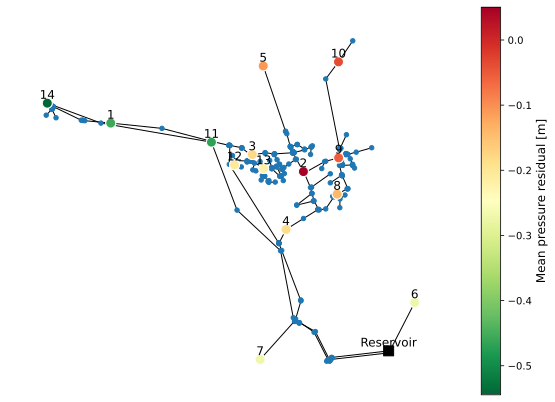

In [ ]:
q_test, h_test = hydraulic_solver(wdn, data_test['d'], data_test['h0'], C=C_1)
mse_test = loss_fun(h_test, data_test['h_data']).value
mse_test

residual_1 = h_test[sensor_idx,:] - data_test['h_data']
meanresidual=np.mean(residual_1,axis=1)
plot_network(wdn,sensor_idx,vals=meanresidual)

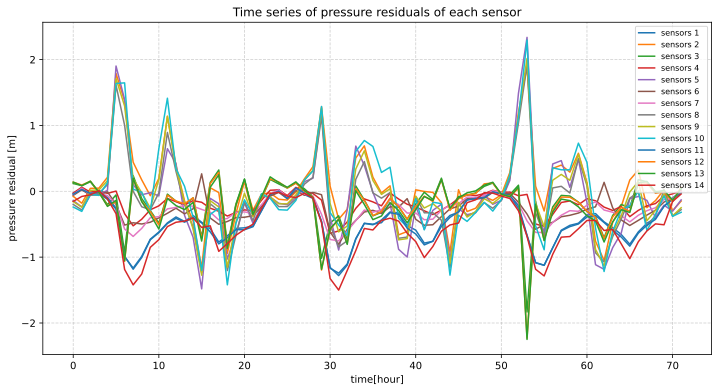

In [ ]:
plt.figure(figsize=(12, 6))
time_hours = np.arange(residual_1.shape[1])
for i in range(residual_1.shape[0]):
    plt.plot(time_hours, residual_1[i, :], label=f'sensors {i+1}')
plt.xlabel('time[hour]')
plt.ylabel('pressure residual [m]')
plt.title('Time series of pressure residuals of each sensor')
plt.legend(loc='upper right', fontsize=8)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

**<u>Question 5:</u>** Comment on the improvement in model accuracy (before vs. after calibration).

Comparing the two spatial residual plots before and after calibration, it’s clear that most sensors move from larger positive or negative residual toward values closer to zero.
The color bar shifts from strong reds/greens (bigger mismatches) to lighter reds/greens (smaller differences).
The residuals in each sensors across the network are reduced. This can also be clearly concluded from the time series of pressure residual graph. The residual upper limit is decrease from 8m(before calibration) to around 2.0m.
This indicate the better performance of the model in simulation. The modified parameters can make the simulated data much closer to the measured data.

#### Discuss the values of the calibrated coefficients $C_1$
Visualise the values of newly calibrated coefficients $C_1$ compared to original model coefficients C.

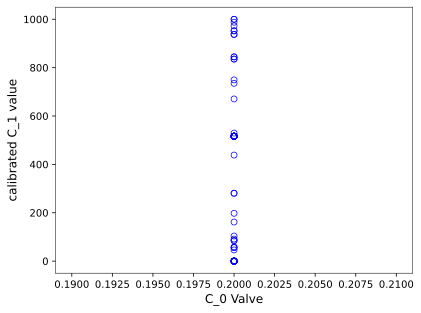

In [ ]:
# C_1 value scatter plot (valves only)
valve_C1 = [C_1[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
fig, ax = plt.subplots()
ax.scatter(valve_C, valve_C1, facecolors='none', edgecolors='b',linewidths=0.75)
ax.set_xlabel('C_0 Valve', fontsize=12)
ax.set_ylabel('calibrated C_1 value', fontsize=12)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

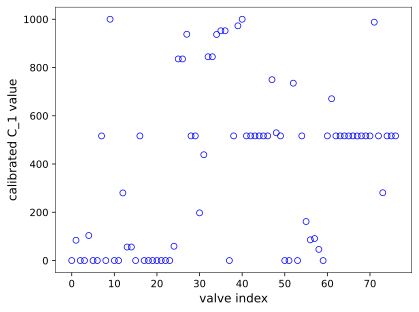

In [ ]:
# C_1 value scatter plot (valves only)
valve_C1 = [C_1[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
fig, ax = plt.subplots()
ax.scatter(range(len(valve_C1)), valve_C1, facecolors='none', edgecolors='b',linewidths=0.75)
ax.set_xlabel('valve index', fontsize=12)
ax.set_ylabel('calibrated C_1 value', fontsize=12)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

Text(0, 0.5, 'Pressure residual [m]')

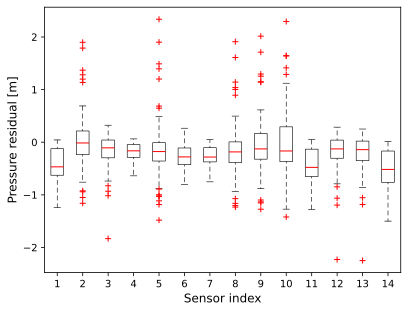

In [ ]:
fig, ax = plt.subplots()
boxplot = ax.boxplot(residual_1.T, medianprops=dict(color="red", linewidth=1.0), flierprops=dict(marker="+", markeredgecolor="red"), whiskerprops=dict(linestyle=(5, (8, 5)), linewidth=0.6), boxprops=dict(color='black', linewidth=0.6), capprops=dict(linewidth=0.6))
ax.set_xlabel('Sensor index', fontsize=12)
ax.set_ylabel('Pressure residual [m]', fontsize=12)

**<u>Question 6:</u>** Comment on the values of parameter estimates in and explain the results of the calibration without regularisation.

Before calibration, the C0 of all valves is considered to be 0.2. After non regularized calibration, a large amount of data is increased to tens and hundreds. Without additional penalties, the model only needs to minimize the head residual: it will significantly increase the loss coefficient of local valves to compensate for other losses or requirements that may not be accurately characterized in the model.The aim of calibration is making the overall predicted data as close to the observed data as possible (making the prediction performance better). However, without regularization, a problem is overfitting. Some C of valves may exaggerating excessively.

### Part 2: Hydraulic model calibration (with regularisation)

In order to reduce the underdeterminedness of the hydraulic model calibration problem (and improve the accuracy of the calibrated model), regularisation can be applied to incorporate prior knowledge about the expected variance or sparsity pattern of parameters $\theta$. Use the code provided in Weeks 5 and 6, and modify as necessary below to calibrate the hydraulic model with regularisation, using the same train data as before.

#### Definition of the regularisation function
Ridge regression (l2-regularisation) shrinks parameter estimates (without actually driving them to 0) in the hopes of reducing variance and improving prediction accuracy while lasso regression (-regularisation) encourages sparsity, driving many parameter estimates exactly to zero.

**<u>Question 7:</u>** Based on your answer to Question 6, comment on the expected variance or sparsity pattern of $\theta$. What type of regularisation (ridge or lasso) term should be included in the objective function of the model calibration problem?

In calibration without regularization, the model make some valve coefficients to become very high, but most of them are not high or around 0.2. There may be some valves in the system that are actually "half closed" or "almost not working", so we want to show a certain sparsity in the parameter distribution. Keep the valve coefficients that really have a significant impact on the system high, while those that have a minimal impact or are nearly closed converge to 0.L1 regular (Lasso) is more appropriate. It not only reduces overfitting, but also highlights valves that really have a significant impact on the head distribution of the system

The loss function is defined as:

In [ ]:
Lamda = 0.0001

In [ ]:
def reg_fun(h, h_0):
    return ( 1/len(h_data.flatten()) ) * cp.sum( ( h[sensor_idx, :] - h_data )**2 ) + Lamda * cp.norm(theta,  1)

#### Solve the parameter estimation problem using the train dataset
Solve the hydraulic model calibration problem with regularisation.

In [ ]:
# unload network training data
n_exp = link_df['n_exp']
d = data_train['d']
h_data = data_train['h_data']
h0 = data_train['h0'].reshape(-1, 1).T

# define SCP problem parameters
Ki = np.inf
iter_max = 50
delta_k = 100
C_up_valve = 1000
C_lo_valve = 1e-4

# initialise values
theta_k = C_0
q_k, h_k = hydraulic_solver(wdn, d, h0, C=theta_k)
a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
objval_k = reg_fun(h_k, h_data).value

for k in range(iter_max):

    # decision variables
    q = cp.Variable((net_info['np'], nt_train))
    h = cp.Variable((net_info['nn'], nt_train))
    theta = cp.Variable(net_info['np'])

    # objective function (defined using CVXPY functions)
    loss = ( 1/len(h_data.flatten()) ) * cp.sum_squares( h[sensor_idx,:] - h_data )
    objective = cp.Minimize(loss+Lamda*cp.norm((theta), 1))

    # hydraulic feasibility constraints
    constraints = []
    for t in range(nt_train):
        # energy and mass constraints
        constraints += [
            cp.multiply(b1_k[:, t], q_k[:, t]) + cp.multiply(cp.multiply(n_exp, a11_k[:, t]), q[:, t]) + cp.multiply(b2_k[:, t], theta) + A12 @ h[:, t] + A10 @ h0[:, t] == 0,
            A12.T @ q[:, t] == d[:, t]
        ]

    # trust region constraints
    constraints += [
        cp.norm(theta - theta_k, 'inf') <= delta_k
    ]

    # variable bounds
    lower_bound_pipe = [theta[idx] >= C_lo_valve for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
    constraints += lower_bound_pipe
    upper_bound_pipe = [theta[idx] <= C_up_valve for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
    constraints += upper_bound_pipe

    # valve minor loss coefficient constraints
    valve_constraints = [theta[idx] == C_0[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
    constraints += valve_constraints

    # solve optimisation problem
    problem = cp.Problem(objective, constraints)
    cvx_val = problem.solve(solver=cp.ECOS, max_iters=1000, verbose=False)

    # store optimal solution and compute actual and predicted decrease in objval
    theta_tilde = theta.value
    [q_tilde, h_tilde] = hydraulic_solver(os.path.join(net_dir, net_name), d, h0, C=theta_tilde)
    objval_tilde = reg_fun(h_tilde, h_data).value

    predicted_decrease = objval_k - cvx_val
    actual_decrease = objval_k - objval_tilde

    # evaluate latest SCP iteration
    if actual_decrease / predicted_decrease >= 0.1:
        objval_old = objval_k
        theta_k = theta_tilde
        q_k = q_tilde
        h_k = h_tilde
        objval_k = objval_tilde
        a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
        Ki = np.abs(objval_old - objval_k) / np.abs(objval_old)
        delta_k = 1.1 * delta_k
        print(f"Iteration {k} successful! Update estimate and increase trust region size. \n")

    else:
        delta_k = 0.25 * delta_k
        print(f"Iteration {k} unsuccessful! Return to previous estimate and reduce trust region size. \n")

    print(f"{k} {objval_k} {Ki} {delta_k} \n")

    if Ki <= 1e-3 or np.abs(objval_k) <= 1e-2 or delta_k <= 1e-1:
        break

Iteration 0 successful! Update estimate and increase trust region size. 

0 4.122327143190391 0.7300693011400216 110.00000000000001 

Iteration 1 successful! Update estimate and increase trust region size. 

1 3.64592556488952 0.11556617457880113 121.00000000000003 

Iteration 2 successful! Update estimate and increase trust region size. 

2 3.3529298836150234 0.08036249672677427 133.10000000000005 

Iteration 3 successful! Update estimate and increase trust region size. 

3 3.2001331290498762 0.04557111537340189 146.41000000000008 

Iteration 4 successful! Update estimate and increase trust region size. 

4 3.091062188813689 0.03408325086418215 161.0510000000001 

Iteration 5 successful! Update estimate and increase trust region size. 

5 3.0370374436399787 0.017477728325629185 177.15610000000012 

Iteration 6 unsuccessful! Return to previous estimate and reduce trust region size. 

6 3.0370374436399787 0.017477728325629185 44.28902500000003 

Iteration 7 successful! Update estimate a

Store the solution (i.e. new coefficients `theta_k`) as $C_2$.

In [ ]:
C_2 = theta_k
mse_train_2 = loss_fun(h_k, data_train['h_data']).value
mse_train_2

0.28182400619332443

Evaluate final model error and visualise head residuals corresponding to *test* dataset.

In [ ]:
q_test, h_test = hydraulic_solver(wdn, data_test['d'], data_test['h0'], C=C_2)
mse_test = loss_fun(h_test, data_test['h_data']).value
mse_test

0.28624371602916443

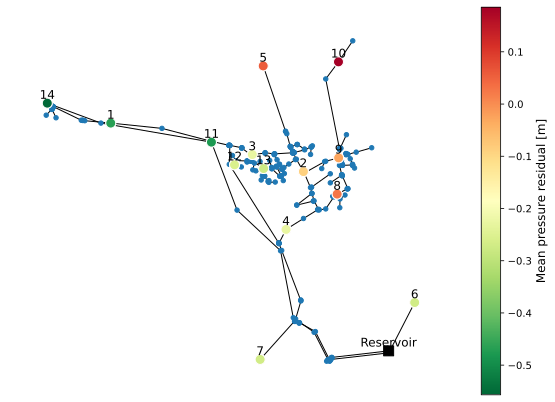

In [ ]:
q_test, h_test = hydraulic_solver(wdn, data_test['d'], data_test['h0'], C=C_2)
mse_test = loss_fun(h_test, data_test['h_data']).value
mse_test

residual_2 = h_test[sensor_idx,:] - data_test['h_data']
meanresidual_2=np.mean(residual_2,axis=1)
plot_network(wdn,sensor_idx,vals=meanresidual_2)

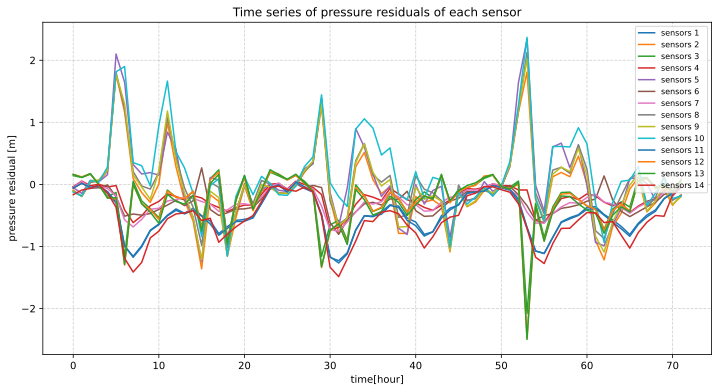

In [ ]:
plt.figure(figsize=(12, 6))
time_hours = np.arange(residual_2.shape[1])
for i in range(residual_2.shape[0]):
    plt.plot(time_hours, residual_2[i, :], label=f'sensors {i+1}')
plt.xlabel('time[hour]')
plt.ylabel('pressure residual [m]')
plt.title('Time series of pressure residuals of each sensor')
plt.legend(loc='upper right', fontsize=8)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Text(0, 0.5, 'After calibration pressure residual [m]')

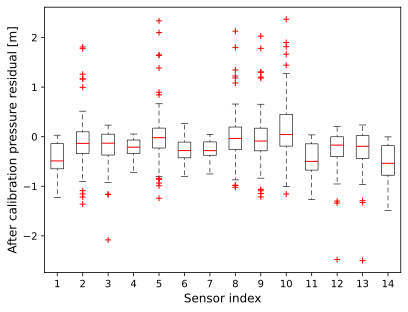

In [ ]:
fig, ax = plt.subplots()
boxplot = ax.boxplot(residual_2.T, medianprops=dict(color="red", linewidth=1.0), flierprops=dict(marker="+", markeredgecolor="red"), whiskerprops=dict(linestyle=(5, (8, 5)), linewidth=0.6), boxprops=dict(color='black', linewidth=0.6), capprops=dict(linewidth=0.6))
ax.set_xlabel('Sensor index', fontsize=12)
ax.set_ylabel('After calibration pressure residual [m]', fontsize=12)

**<u>Question 8:</u>** Comment on the improvement in model accuracy after calibration with regularisation.

After incorporating regularization, the model no longer fits the measured data by setting a few valve coefficients to be too large. Instead, it controls the parameters within a more reasonable range through the penalty term. This helps to avoid overfitting and ensures a more balanced distribution of parameter values. By preventing the calibration process from overemphasizing certain valves, the model maintains a more consistent approach to matching measured data across all sensor locations. The residuals of the training set decrease, and the error of the test set also reduces, indicating that the model's generalization ability has improved. Additionally, the extreme values are reduced, facilitating subsequent analysis. Regularization calibration enhances the prediction accuracy and makes the calibrated model more interpretable.

#### Discuss the values of the calibrated coefficients $C_2$
Visualise the values of newly calibrated coefficients $C_2$.

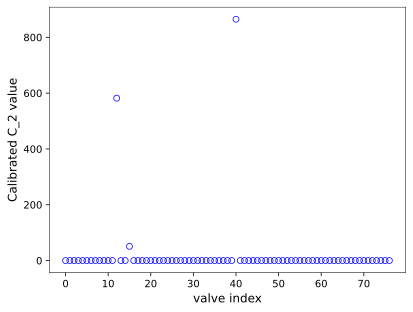

In [ ]:
# C_2 value scatter plot (valves only)
valve_C_2 = [C_2[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
fig, ax = plt.subplots()
ax.scatter(range(len(valve_C)), valve_C_2, facecolors='none', edgecolors='b',linewidths=0.75)
ax.set_xlabel('valve index', fontsize=12)
ax.set_ylabel('Calibrated C_2 value', fontsize=12)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

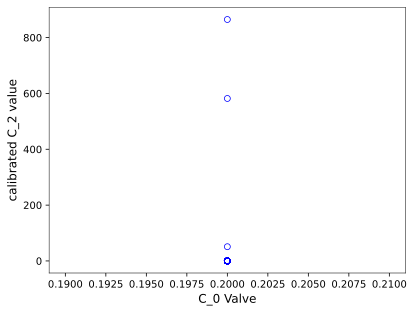

In [ ]:
valve_C2 = [C_2[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
fig, ax = plt.subplots()
ax.scatter(valve_C, valve_C2, facecolors='none', edgecolors='b',linewidths=0.75)
ax.set_xlabel('C_0 Valve', fontsize=12)
ax.set_ylabel('calibrated C_2 value', fontsize=12)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

**<u>Question 9:</u>** Comment on the values of parameter estimates in $C_2$ compared to $C_1$ and explain the results of the calibration with regularisation.

From scatter plots(C1 and C2), it can be seen that in the C1 scatter plot, the coefficients of some valves are quite large, indicating that without regularization, the calibration model raises the local loss coefficients of a few valves to compensate for the losses that are not accurately depicted in the system. In the C2 scatter plot, the extreme values are significantly reduced, only three still high. Calibration with regularization no longer uses extreme coefficients to fit the training set, thereby usually maintaining good simulation accuracy on the test data and improving generalization ability.

**<u>Question 10:</u>** Do the calibrated local loss coefficient values in $C_2$ corroborate the conclusions of the preliminary analysis about the most likely sources of error in the EXNING model (existence/location of unknowingly closed valves)? Summarise your findings (100-150 words + 1-2 figures) and provide recommendations to AW to validate your proposed hydraulic model update.


According to the C2 calibration, the local loss coefficient of a few valves has significantly increased, which is consistent with the previous inference. Comparing Figure 1 (pre calibration box plot) and Figure 2 (post calibration box plot), it can be observed that the pressure residual distribution of most sensors has significantly narrowed, and high error rates have significantly decreased, indicating a significant improvement in the simulation accuracy of the model near these high loss valves(narrow to around 1.0m). This shows the previous inference "high actual resistance of the valve" is one of the main reasons of error of model.
I suggest Anglian Water (AW) conduct on-site inspections of these valves with significantly elevated C2 values to determine whether they are indeed in a half-closed state or have abnormal resistance. Update the loss data of the valves and bends.

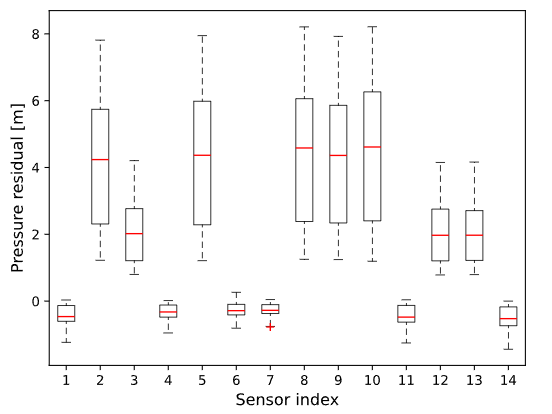

Figure 1: pressure residual before calibration

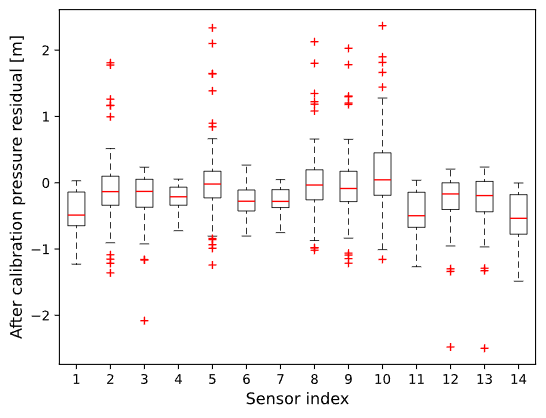

Figure 2: Pressure residual after calibration